# 濾波Q&A

1. 先處理 NaN、inf 還先濾波??
    > 先處理 Nan、inf

2. ### 刪除Channel 還是刪除人??
    > 先刪除 Channel，不行再刪除人

In [1]:
# import 必須資料
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 確認資料夾，如果沒放同一個資料夾就要改這裡
print(os.getcwd())
# path = 'C:\\Users\\User\\Desktop\\Machine Learning\\police2_all_data\\【警察】DATA\\raw data_all\\新\\VFT'
# os.chdir(path)

c:\Users\User\Desktop\VFT\VFT(2)


In [3]:
# Find all csv files
all_csv = glob.glob('VFT/*.csv')
print("length = ", len(all_csv))

# 計算沒有重複的名字
# 刻在你心裡的名字
count_name = []
for banana in all_csv :
    real_name = banana.split('_')[-1].split('.')[0]
    if real_name  not in count_name:
        count_name.append(real_name)

print('unique name = ', len(count_name))

# 看前五個
all_csv[:5]

length =  39
unique name =  39


['VFT\\2021_3_26_1012_Carnelian.csv',
 "VFT\\2021_3_26_1045_Kal'tsit.csv",
 'VFT\\2021_3_26_1118_Skadi-the-Corrupting-Heart.csv',
 'VFT\\2021_3_26_1143_Gladiia.csv',
 'VFT\\2021_3_26_1405_Ash.csv']

### 這裡注意一下

`df = df.iloc[:, :9]` 是因為Ch4 經過考量捨棄，為捨棄前請全取

In [4]:
df = pd.read_csv(all_csv[4])
df = df.iloc[:, :9]
df.columns

Index(['Time_Host', 'Time_Arduino', 'easingdata', 'CH1_Oxy', 'CH1_Deoxy',
       'CH2_Oxy', 'CH2_Deoxy', 'CH3_Oxy', 'CH3_Deoxy'],
      dtype='object')

In [5]:
# check null 必
df.isna().sum()

Time_Host       0
Time_Arduino    0
easingdata      0
CH1_Oxy         0
CH1_Deoxy       0
CH2_Oxy         0
CH2_Deoxy       0
CH3_Oxy         0
CH3_Deoxy       0
dtype: int64

# 畫原圖

1. 用 `subplot()` 可以自動一格一格畫
2. 記得 `tight_layout`

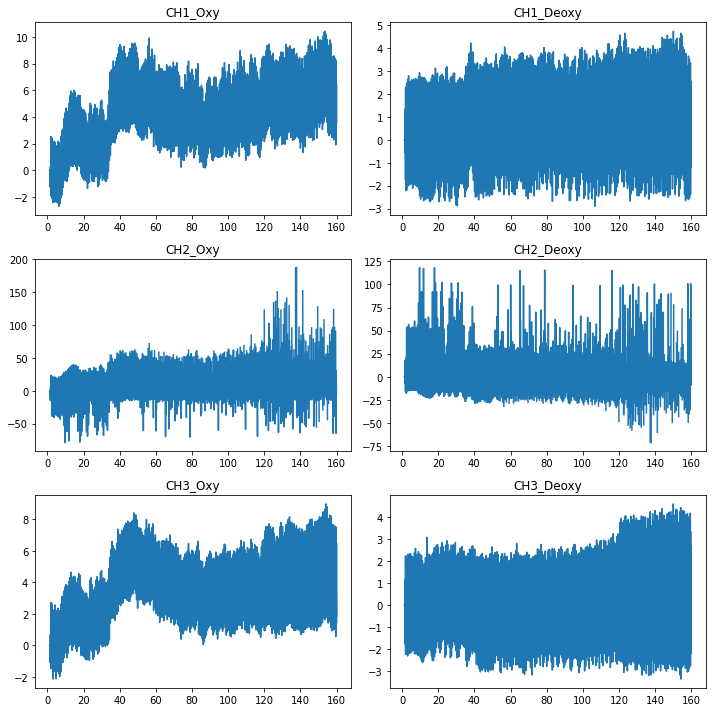

In [6]:
plt.figure(figsize= (10, 10))

for i, cols in enumerate(df.columns[3:]):
    plt.subplot(3, 2, i+1)
    plt.plot(df['Time_Host'], df[cols])
    plt.title(cols)
    plt.tight_layout()
plt.show()

# 濾波

1. 四階butterword (可以更改)  -> 可自行查
```
from scipy import signal
b, c = signal.butter(4, 0.01, 'lowpass')
```

$W_n = \frac{f}{f_s/2}$ = $\frac{截止頻率}{取樣頻率/ 2}$

我們的

$\frac{0.01}{24/2} \approx 0.0083$

因為其實 0.01 ~ 0.015都可以，所以取0.012，$W_n就 0.01$

In [7]:
# 開始濾波
from scipy import signal

# 0.01 
b, c = signal.butter(4, 0.01, 'lowpass')

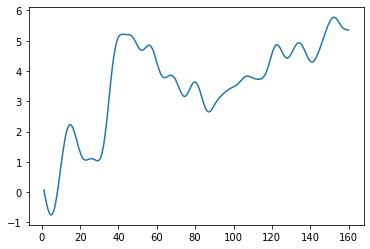

In [8]:
# 濾一張看看
CH1_HbO2_filter_a = signal.filtfilt(b, c, df.CH1_Oxy)
CH1_HbO2_filter_a

plt.plot(df.Time_Host, CH1_HbO2_filter_a)
plt.show()

### 請用for，不要一行一行濾

In [9]:
# 全部一起濾波
need_filt = ['CH1_Oxy', 'CH1_Deoxy', 'CH2_Oxy', 'CH2_Deoxy', 'CH3_Oxy', 'CH3_Deoxy']

for need in need_filt:
    df[need] = signal.filtfilt(b, c, df[need])

df

,Time_Host,Time_Arduino,easingdata,CH1_Oxy,CH1_Deoxy,CH2_Oxy,CH2_Deoxy,CH3_Oxy,CH3_Deoxy
0,1.223,0.04,0.00,0.071013,-0.269972,NaN,NaN,-0.871894,0.627588
1,1.243,0.10,0.00,0.053403,-0.254427,NaN,NaN,-0.851776,0.610879
2,1.264,0.16,0.00,0.035780,-0.238918,NaN,NaN,-0.831830,0.594298
3,1.284,0.21,0.00,0.018151,-0.223453,NaN,NaN,-0.812063,0.577851
4,1.304,0.27,0.00,0.000525,-0.208036,NaN,NaN,-0.792481,0.561545
...,...,...,...,...,...,...,...,...,...
2887,159.764,159.52,3.41,5.355740,1.220246,NaN,NaN,4.060909,0.645798
2888,159.826,159.57,3.36,5.355681,1.220218,NaN,NaN,4.060867,0.645802
2889,159.867,159.63,3.29,5.355633,1.220195,NaN,NaN,4.060833,0.645805
2890,159.928,159.68,3.45,5.355594,1.220176,NaN,NaN,4.060805,0.645807


### 她媽乾淨，但是CH2不見了，那是因為有nan

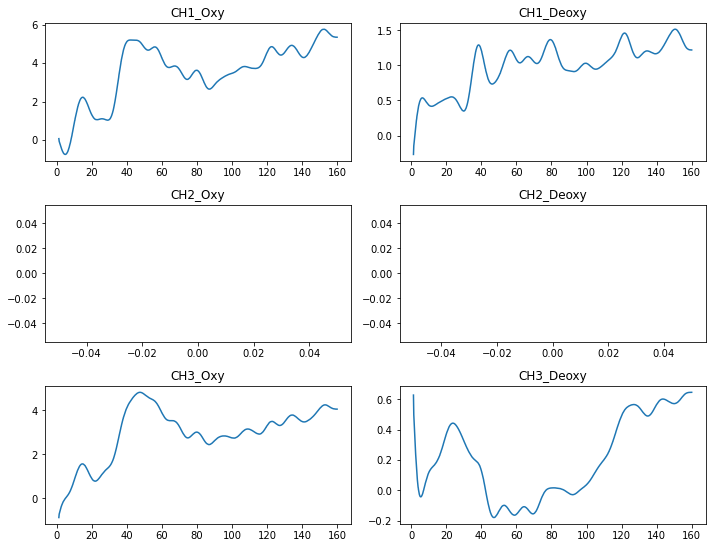

In [10]:
# 濾完了
plt.figure(figsize= (10, 10))

for i, cols in enumerate(need_filt):
    plt.subplot(4, 2, i+1)
    plt.plot(df['Time_Host'], df[cols])
    plt.title(cols)
    plt.tight_layout()
plt.show()

# 正式開始做  -> 下面才是正文，上面都嘗試
### 1. 看 NuN 、infinite 

In [11]:
check_state = pd.DataFrame()

for i in all_csv:
    filename = i.split('_')[-1]
    name = filename.split('.')[0] 
    dfs = pd.read_csv(i)
    dfs = dfs.iloc[:, :9]
    # check_state[name + '_null'] = dfs.isna().sum()
    # check_state[name + '_infinite'] = np.isinf(dfs).sum()
    check_state[name + '_all'] = dfs.isna().sum() + np.isinf(dfs).sum()

check_state.head()

,Carnelian_all,Kal'tsit_all,Skadi-the-Corrupting-Heart_all,Gladiia_all,Ash_all,Dusk_all,Saga_all,Archetto_all,Mountain_all,Rosmontis_all,...,Bena_all,Kafka_all,Robin_all,Amiya_all,Whisperain_all,Mint_all,April_all,Bibeak_all,Warfarin_all,Specter_all
Time_Host,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Time_Arduino,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
easingdata,0,0,0,0,0,0,256,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH1_Oxy,0,0,0,0,0,0,1357,0,0,0,...,0,0,6,0,0,0,0,0,0,0
CH1_Deoxy,0,0,0,0,0,0,1357,0,0,0,...,0,0,6,0,0,0,0,0,0,0


### 看一下各Channel狀況

> 太多GG的就要去除掉

In [12]:
check_state.sum(axis= 1)

Time_Host          0
Time_Arduino       0
easingdata       256
CH1_Oxy         1363
CH1_Deoxy       1363
CH2_Oxy         2529
CH2_Deoxy       2529
CH3_Oxy            8
CH3_Deoxy          8
dtype: int64

### 看一下每個人的狀況

> 太多Miss的就要去除掉

In [13]:
rank = check_state.sum(axis= 0).sort_values(ascending= False)[:15]
rank

Saga_all           3218
Specter_all        2118
Ash_all             876
Dusk_all            604
Bagpipe_all         444
Blaze_all           410
Suzuran_all         186
Surtr_all            76
Ceobe_all            52
SilverAsh_all        36
Saria_all            12
Robin_all            12
Whisperain_all        8
Heavyrain_all         4
Nightingale_all       0
dtype: int64

# NaN + inf > 1000 刪除

> 閥值自己訂


In [14]:
print(len(all_csv))
bad = rank[rank >1000].index
for alls in all_csv:
    for bads in bad:
        name1 = bads.split("_")[0]

        if name1 in alls:
            print(alls)
            all_csv.remove(alls)

print(len(all_csv))

39
VFT\2021_3_26_1520_Saga.csv
VFT\2021_4_23_1650_Specter.csv
37


# 補值

> 就算少，還是不可以有 null, inf

1. ffill -> 最好用，補前值
2. bfill -> 補厚值
3. `pandas.DataFrame.interpolate`  -> 1, 2, ?, 4, 5  $\rightarrow$ ? = 3



In [15]:
df = pd.read_csv(all_csv[4])
dfs = df.iloc[:, :9]
np.isinf(dfs).sum()

Time_Host         0
Time_Arduino      0
easingdata        0
CH1_Oxy           0
CH1_Deoxy         0
CH2_Oxy         438
CH2_Deoxy       438
CH3_Oxy           0
CH3_Deoxy         0
dtype: int64

In [16]:
dfs[np.isinf(dfs)]= None
dfs = dfs.ffill(axis= 1)
np.isinf(dfs).sum()

Time_Host       0
Time_Arduino    0
easingdata      0
CH1_Oxy         0
CH1_Deoxy       0
CH2_Oxy         0
CH2_Deoxy       0
CH3_Oxy         0
CH3_Deoxy       0
dtype: int64

Index(['Time_Host', 'Time_Arduino', 'easingdata', 'CH1_Oxy', 'CH1_Deoxy',
       'CH2_Oxy', 'CH2_Deoxy', 'CH3_Oxy', 'CH3_Deoxy'],
      dtype='object')


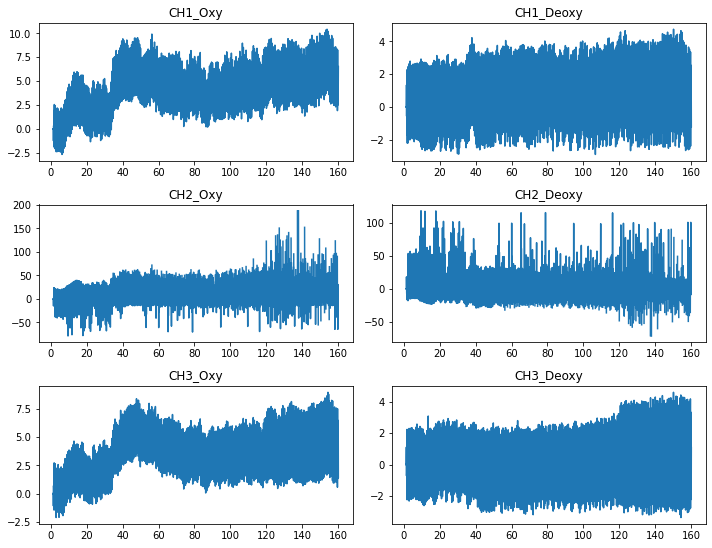

In [17]:
print(dfs.columns)

plt.figure(figsize= (10, 10))

for i, cols in enumerate(need_filt):
    plt.subplot(4, 2, i+1)
    plt.plot(dfs['Time_Host'], df[cols])
    plt.title(cols)
    plt.tight_layout()
plt.show()

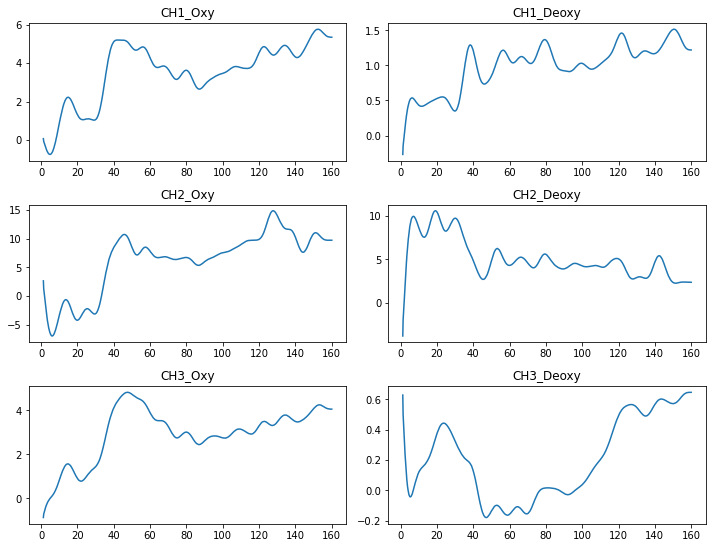

In [18]:
# channel2 有了

need_filt = ['CH1_Oxy', 'CH1_Deoxy', 'CH2_Oxy', 'CH2_Deoxy', 'CH3_Oxy', 'CH3_Deoxy']

for need in need_filt:
    dfs[need] = signal.filtfilt(b, c, dfs[need])

plt.figure(figsize= (10, 10))

for i, cols in enumerate(need_filt):
    plt.subplot(4, 2, i+1)
    plt.plot(dfs['Time_Host'], dfs[cols])
    plt.title(cols)
    plt.tight_layout()
plt.show()

# $\star$ 批量濾波  -> "測試"



In [19]:
check_states = pd.DataFrame()
need_filt = ['CH1_Oxy', 'CH1_Deoxy', 'CH2_Oxy', 'CH2_Deoxy', 'CH3_Oxy', 'CH3_Deoxy']
b, c = signal.butter(4, 0.01, 'lowpass')

for i in all_csv:
    filename = i.split('_')[-1]
    name = filename.split('.')[0] 

    dfs = pd.read_csv(i)
    dfs = dfs.iloc[:, :9]

    dfs[np.isinf(dfs)]= None
    dfs = dfs.ffill(axis= 1)

    for needs in need_filt:
        dfs[needs] = signal.filtfilt(b, c, dfs[needs])
        
    # print(name, "\n", dfs.iloc[:, 3:].describe().loc[['min', 'max']])

    # check_states[name + '_null'] = dfs.isna().sum()
    # check_states[name + '_infinite'] = np.isinf(dfs).sum()
    check_states[name + '_all'] = dfs.isna().sum()+ np.isinf(dfs).sum()



## 確認有濾好，沒有null

In [20]:
check_states.sum(axis= 1).sort_values(ascending= False)

Time_Host       0
Time_Arduino    0
easingdata      0
CH1_Oxy         0
CH1_Deoxy       0
CH2_Oxy         0
CH2_Deoxy       0
CH3_Oxy         0
CH3_Deoxy       0
dtype: int64

In [21]:
check_states.sort_values(by= 'CH2_Deoxy', axis= 1, ascending = False)

,Carnelian_all,Aak_all,Hellagur_all,SilverAsh_all,Saria_all,Nightingale_all,Hoshiguma_all,Shining_all,Heavyrain_all,Bena_all,...,Rosmontis_all,Blemishine_all,Mudrock_all,Surtr_all,Eunectes_all,Thorns_all,Suzuran_all,Роса_all,Weedy_all,Warfarin_all
Time_Host,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Time_Arduino,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
easingdata,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH1_Oxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH1_Deoxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH2_Oxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH2_Deoxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH3_Oxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH3_Deoxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
check_states.sort_values(by= 'CH1_Deoxy', axis= 1, ascending = False)

,Carnelian_all,Aak_all,Hellagur_all,SilverAsh_all,Saria_all,Nightingale_all,Hoshiguma_all,Shining_all,Heavyrain_all,Bena_all,...,Rosmontis_all,Blemishine_all,Mudrock_all,Surtr_all,Eunectes_all,Thorns_all,Suzuran_all,Роса_all,Weedy_all,Warfarin_all
Time_Host,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Time_Arduino,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
easingdata,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH1_Oxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH1_Deoxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH2_Oxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH2_Deoxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH3_Oxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CH3_Deoxy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
rank = check_states.sum(axis= 0).sort_values(ascending= False)[:10]
rank

Carnelian_all      0
Aak_all            0
Hellagur_all       0
SilverAsh_all      0
Saria_all          0
Nightingale_all    0
Hoshiguma_all      0
Shining_all        0
Heavyrain_all      0
Bena_all           0
dtype: int64

# 看一下濾波完的大概

> 有沒有最大值跟最小值根本差不多的，就不行

In [24]:
check_states = pd.DataFrame()
need_filt = ['CH1_Oxy', 'CH1_Deoxy', 'CH2_Oxy', 'CH2_Deoxy', 'CH3_Oxy', 'CH3_Deoxy']
b, c = signal.butter(4, 0.01, 'lowpass')

for i in all_csv:
    filename = i.split('_')[-1]
    name = filename.split('.')[0] 

    dfs = pd.read_csv(i)
    dfs = dfs.iloc[:, :9]

    dfs[np.isinf(dfs)]= None
    dfs = dfs.ffill(axis= 1)

    for needs in need_filt:
        dfs[needs] = signal.filtfilt(b, c, dfs[needs])
        
    print(name, "\n", dfs.iloc[:, 3:].describe().loc[['min', 'max']])
    

Carnelian 
       CH1_Oxy  CH1_Deoxy    CH2_Oxy  CH2_Deoxy   CH3_Oxy  CH3_Deoxy
min -1.969281  -4.314400 -10.187933  -4.973838 -4.000991  -5.321925
max  0.981209   0.715221   0.268886   5.087384  0.186520   2.011421
Kal'tsit 
       CH1_Oxy  CH1_Deoxy   CH2_Oxy  CH2_Deoxy   CH3_Oxy  CH3_Deoxy
min -1.371203  -0.972132 -3.706960  -0.276584 -2.902949   0.092281
max  1.598216   3.292501  2.967943   3.996321  0.274751   3.636667
Skadi-the-Corrupting-Heart 
       CH1_Oxy  CH1_Deoxy   CH2_Oxy  CH2_Deoxy   CH3_Oxy  CH3_Deoxy
min -2.613835  -3.370687 -4.690012  -3.806691 -4.071434  -1.905777
max  1.601120   1.014741  2.144775   0.907559  4.521770   1.752627
Gladiia 
       CH1_Oxy  CH1_Deoxy   CH2_Oxy  CH2_Deoxy   CH3_Oxy  CH3_Deoxy
min -0.120718  -1.434059  0.233457  -1.053184 -0.154958  -0.334591
max  1.489374   0.026650  4.247909   0.354855  2.583461   0.846369
Ash 
       CH1_Oxy  CH1_Deoxy    CH2_Oxy  CH2_Deoxy   CH3_Oxy  CH3_Deoxy
min -0.751291  -0.269972  -6.957033  -3.810656 -0.871894 

# $\star$ MinMax "測試"  -> 消除個體差異

> 消除個體差異

In [25]:
dfs.iloc[:, 3:] = (dfs.iloc[:, 3:] - dfs.iloc[:, 3:].min())/(dfs.iloc[:, 3:].max()- dfs.iloc[:, 3:].min())
dfs

,Time_Host,Time_Arduino,easingdata,CH1_Oxy,CH1_Deoxy,CH2_Oxy,CH2_Deoxy,CH3_Oxy,CH3_Deoxy
0,1.211,0.04,0.00,0.773183,0.342028,0.721114,0.308785,0.704791,0.310244
1,1.230,0.10,0.00,0.775239,0.339656,0.724566,0.307541,0.712364,0.309125
2,1.251,0.15,0.00,0.777240,0.337274,0.727984,0.306286,0.719914,0.308001
3,1.272,0.21,0.00,0.779185,0.334883,0.731367,0.305019,0.727436,0.306873
4,1.293,0.26,0.00,0.781071,0.332485,0.734712,0.303741,0.734926,0.305740
...,...,...,...,...,...,...,...,...,...
2887,159.796,159.56,-2.67,0.000376,0.004461,0.079581,0.004692,0.088142,0.041787
2888,159.836,159.62,-2.69,0.000378,0.004462,0.079580,0.004694,0.088143,0.041789
2889,159.899,159.67,-2.70,0.000379,0.004463,0.079579,0.004696,0.088144,0.041791
2890,159.981,159.73,-2.72,0.000380,0.004464,0.079578,0.004697,0.088145,0.041792


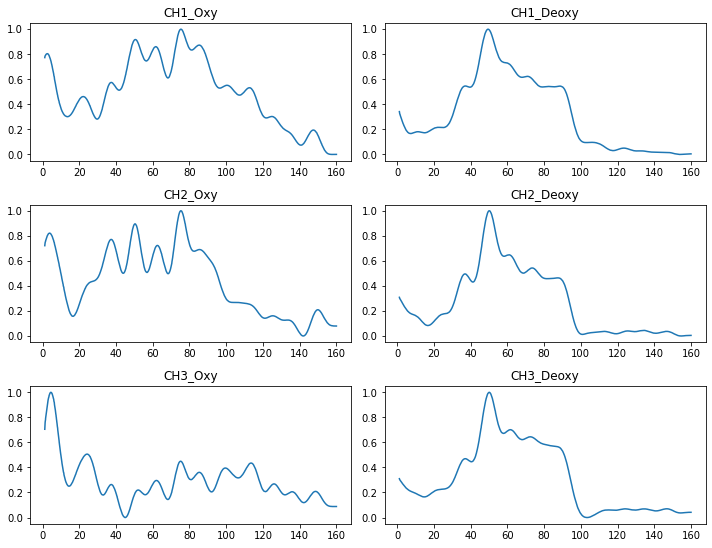

In [26]:
plt.figure(figsize= (10, 10))
for i, cols in enumerate(need_filt):
    plt.subplot(4, 2, i+1)
    plt.plot(dfs['Time_Host'], dfs[cols])
    plt.title(cols)
    plt.tight_layout()
plt.show()

# 統一:  Lowpass filter + Minmax + to_csv


In [27]:
os.getcwd()
try:
    os.mkdir('Filtered')
except:
    pass

In [28]:
for files in all_csv:
    # 分檔名
    filename = files.split('_')[-1]
    name = filename.split('.')[0] 

    #讀跟切
    dfs = pd.read_csv(files)
    dfs = dfs.iloc[:, :9]

    # inf to nan to ffill
    dfs[np.isinf(dfs)]= None
    dfs = dfs.ffill(axis= 1)

    for needs in need_filt:
        dfs[needs] = signal.filtfilt(b, c, dfs[needs])

    # minmax
    dfs.iloc[:, 3:] = (dfs.iloc[:, 3:] - dfs.iloc[:, 3:].min())/(dfs.iloc[:, 3:].max()- dfs.iloc[:, 3:].min())
        
    dfs.to_csv('Filtered\\'+ "F_" + filename)

# 讀取濾波完的 .csv，並畫圖
> ### time 變成 index 可以直接用loc切

In [32]:
alls = glob.glob('Filtered/*.csv')
alls[:5]

['Filtered\\F_Aak.csv',
 'Filtered\\F_Amiya.csv',
 'Filtered\\F_April.csv',
 'Filtered\\F_Archetto.csv',
 'Filtered\\F_Ash.csv']

In [33]:
check_df = pd.read_csv(alls[5], index_col= 'Unnamed: 0').drop(columns= ['Time_Arduino', 'easingdata'])
print(check_df.dtypes)

check_df = check_df.set_index('Time_Host')
check_df

Time_Host    float64
CH1_Oxy      float64
CH1_Deoxy    float64
CH2_Oxy      float64
CH2_Deoxy    float64
CH3_Oxy      float64
CH3_Deoxy    float64
dtype: object


,CH1_Oxy,CH1_Deoxy,CH2_Oxy,CH2_Deoxy,CH3_Oxy,CH3_Deoxy
Time_Host,,,,,,
0.035,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.381,0.982881,0.982231,0.982285,0.982622,0.984898,0.982100
1.402,0.965770,0.964464,0.964580,0.965240,0.969798,0.964203
1.423,0.948675,0.946706,0.946891,0.947860,0.954709,0.946314
1.444,0.931601,0.928965,0.929225,0.930490,0.939634,0.928441
...,...,...,...,...,...,...
159.789,0.416742,0.140978,0.609272,0.223283,0.000010,0.701638
159.852,0.416742,0.140979,0.609269,0.223282,0.000006,0.701641
159.894,0.416741,0.140979,0.609267,0.223281,0.000004,0.701644


# 畫圖

### matplotlib.pyplot 自己練

重點:
1. `facecolor=sns.color_palette('Paired')[1]`  -> 自己配色會比我阿嬤還醜
2. `bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),)1` -> bbox 可以唱bbox

### 階段

* 第一階段: 0 ~ 30  -> rest
* 第二階段: 30 ~ 90  -> Task
* 第三階段: 90 ~ 160  -> recovery

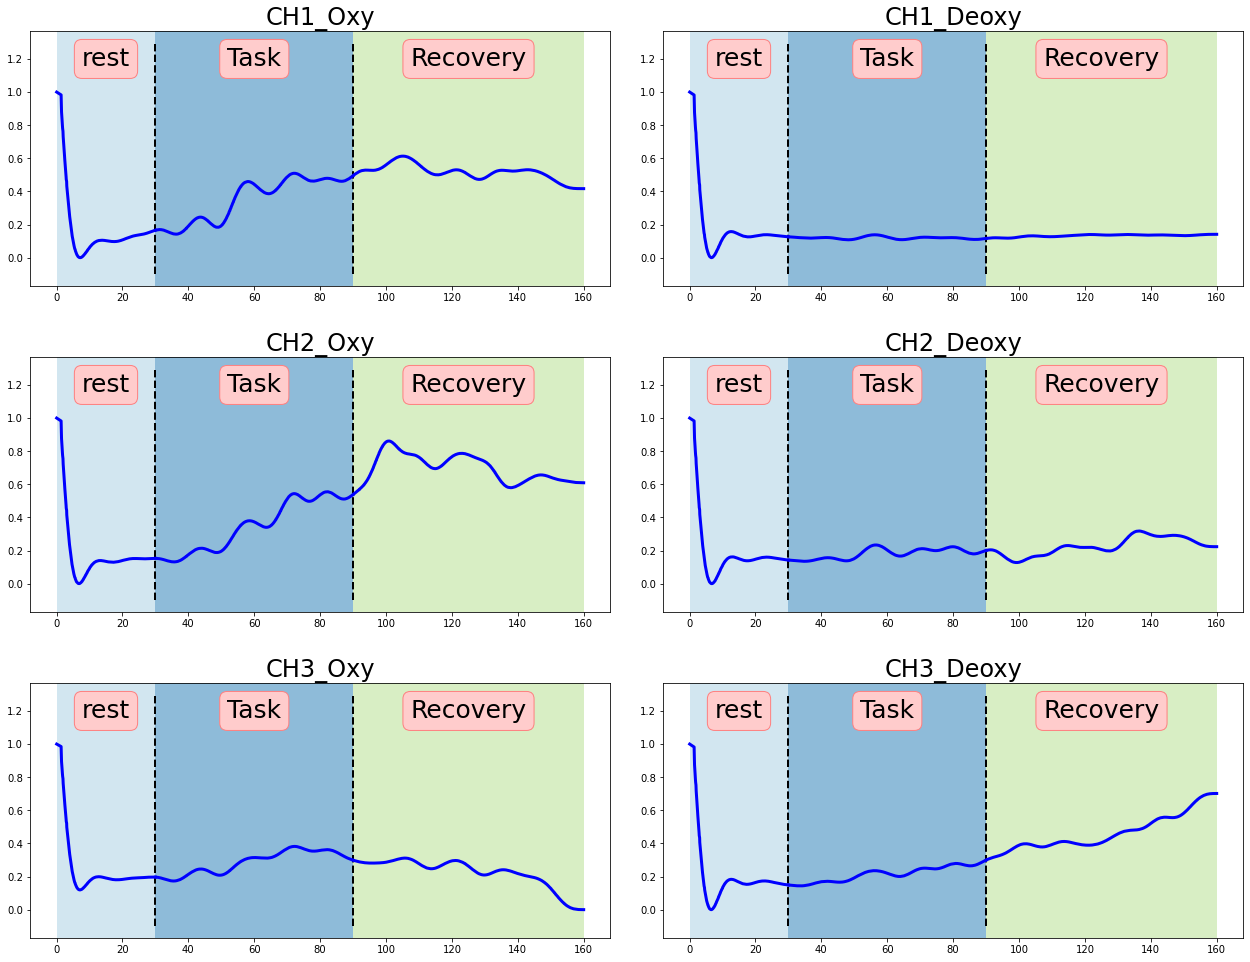

In [34]:
stage1 = 30
stage2 = 90
stage3 = 160
text_size = 25

plt.figure(figsize= (18, 14))
for i, cols in enumerate(check_df):
    plt.subplot(3, 2, i+1)

    # 第一階段
    plt.plot(check_df.loc[:stage1].index, check_df.loc[:stage1][cols], c= 'b',  linewidth=3.0, label= 'Rest')
    plt.axvspan(0, stage1, facecolor=sns.color_palette('Paired')[0], alpha=0.5)
    plt.vlines(stage1, -0.1, 1.3, linestyles= '--', colors= 'black',  linewidth=2.0)
    plt.text(stage1/2, 1.2, "rest", size= text_size, ha="center", va= 'center', bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))

    # 第二階段
    plt.plot(check_df.loc[stage1:stage2].index, check_df.loc[stage1:stage2][cols], c= 'b', linewidth=3.0, label= 'Task')
    plt.axvspan(stage1, stage2, facecolor=sns.color_palette('Paired')[1], alpha=0.5)
    plt.vlines(stage2, -0.1, 1.3, linestyles= '--', colors= 'black',  linewidth=2.0)
    plt.text((stage2 + stage1)/2, 1.2, 'Task', size= text_size, ha="center", va= 'center', bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))

    # 第三階段
    plt.plot(check_df.loc[stage2:stage3].index, check_df.loc[stage2:stage3][cols], c= 'b', linewidth=3.0, label= 'Recovery')
    plt.axvspan(stage2, stage3, facecolor=sns.color_palette('Paired')[2], alpha=0.5)
    plt.text((stage3 + stage2)/2, 1.2, 'Recovery', size= text_size, ha="center", va= 'center', bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))

    plt.title(cols, fontdict={'fontsize': 24})
    plt.tight_layout(pad= 3)
plt.show()